In [ ]:
from google.colab import drive


drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!mkdir model

In [ ]:
import os
import random
import logging
import pickle
import numpy as np
import torch


def configure_workspace(SEED=1873337):
    random.seed(SEED)
    np.random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
    torch.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True

    logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s",
                        datefmt='%H:%M:%S', level=logging.INFO)


def save_pickle(save_to, save_what):
    with open(save_to, mode='wb') as f:
        pickle.dump(save_what, f)


def load_pickle(load_from):
    with open(load_from, 'rb') as f:
        return pickle.load(f)

In [ ]:
import io


def load_bilingual_embeddings(file_name, file_name2, word2idx, embeddings_size, save_to=None):
    if os.path.exists(save_to):
        pretrained_embeddings = torch.from_numpy(np.load(save_to))
        
    else:
        fin = io.open(file_name, 'r', encoding='utf-8', newline='\n', errors='ignore')
        data = {}
        for line in tqdm(fin, desc=f'Reading data from {file_name}', leave=False):
            tokens = line.rstrip().split(' ')
            data[tokens[0]] = np.array(tokens[1:], dtype=np.float)

        fin = io.open(file_name2, 'r', encoding='utf-8', newline='\n', errors='ignore')
        for line in tqdm(fin, desc=f'Reading data from {file_name2}', leave=False):
            tokens = line.rstrip().split(' ')
            data[tokens[0]] = np.array(tokens[1:], dtype=np.float)

        pretrained_embeddings = torch.randn(len(word2idx), embeddings_size)
        initialised = 0
        for idx, word in enumerate(data):
            if word in word2idx:
                initialised += 1
                vector_ = torch.from_numpy(data[word])
                pretrained_embeddings[word2idx.get(word)] = vector_

        pretrained_embeddings[word2idx["<PAD>"]] = torch.zeros(embeddings_size)
        pretrained_embeddings[word2idx["<UNK>"]] = torch.zeros(embeddings_size)
        print(f'Loaded {initialised} vectors and instantiated random embeddings for {len(word2idx) - initialised}')

        np.save(save_to, pretrained_embeddings) # save the file as "outfile_name.npy"
    return pretrained_embeddings

In [ ]:
import nltk
nltk.download('averaged_perceptron_tagger', quiet=True)
from pathlib import Path
from tqdm.auto import tqdm
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader


class TSVDatasetParser(Dataset):
    def __init__(self, _path, _device, is_testing_data=False):
        self.encoded_data = []
        self.is_test_data = is_testing_data
        self.device = _device
        self.read_dataset(_path)

    def strip_sentences(self, sentences):
        _sentences = []
        for i in range(len(sentences)):
            _sentences.append([word.strip() for word in sentences[i] if word])
        return _sentences

    def pos_tag_sentence(self, words):
        pos_tag = nltk.pos_tag(words)   
        return [pos[1] for pos in pos_tag]

    def read_dataset(self, _path):
        with open(_path, encoding="utf-8") as file_:
            lines = file_.read().splitlines()
            if self.is_test_data:
                sentences, pos_tagged = [], []
                for idx in range(0, len(lines)):
                    sentences.append(lines[idx].split())
                    pos_tagged.append(self.pos_tag_sentence(lines[idx].split()))
                self.data_x = self.strip_sentences(sentences)
                self.pos_x = self.strip_sentences(pos_tagged)
            else:
                sentences, pos_tagged, labels = [], [], []
                for idx in range(0, len(lines), 2):
                    sentences.append(lines[idx].split())
                    pos_tagged.append(self.pos_tag_sentence(lines[idx].split()))
                    labels.append(lines[idx + 1].split())
                self.data_x = self.strip_sentences(sentences)
                self.pos_x = self.strip_sentences(pos_tagged)
                self.data_y = self.strip_sentences(labels)

    @staticmethod
    def encode_labels():
        return {'<PAD>': 0, 'B': 1, 'I': 2, 'O': 3}, {0: '<PAD>', 1: 'B', 2: 'I', 3: 'O'}
    
    @staticmethod
    def build_vocabulary(data_x, load_from=None):
        if load_from and Path(load_from).is_file():
            stoi = load_pickle(load_from)
            itos = {key: val for key, val in enumerate(stoi)}
            return stoi, itos
        all_words = [item for sublist in data_x for item in sublist]
        unigrams = sorted(list(set(all_words)))
        stoi = {'<PAD>': 0, '<UNK>': 1}
        start_ = 2
        stoi.update({val: key for key, val in enumerate(unigrams, start=start_)})
        itos = {key: val for key, val in enumerate(stoi)}
        save_pickle(load_from, stoi)
        save_pickle(load_from.replace('stoi', 'itos'), itos)
        return stoi, itos
    
    def encode_dataset(self, word2idx, label2idx, pos2idx):
        if self.is_test_data:
            data_x_stoi, pos_x_stoi = [], []
            for sentence, pos_sentence in tqdm(zip(self.data_x, self.pos_x), desc='Numericalizing Data', leave=False, total=len(self.data_x)):
                data_x_stoi.append(torch.LongTensor([word2idx.get(word, 1) for word in sentence]).to(self.device))
                pos_x_stoi.append(torch.LongTensor([pos2idx.get(pos, 1) for pos in pos_sentence]).to(self.device))

            for i in range(len(data_x_stoi)):
                self.encoded_data.append({'inputs': data_x_stoi[i], 'pos': pos_x_stoi[i], 'outputs': data_x_stoi[i]})
        else:
            data_x_stoi, pos_x_stoi, data_y_stoi = [], [], []
            for sentence, pos_sentence, labels in tqdm(zip(self.data_x, self.pos_x, self.data_y),
                                        desc='Numericalizing Data', leave=False, total=len(self.data_x)):
                data_x_stoi.append(torch.LongTensor([word2idx.get(word, 1) for word in sentence]).to(self.device))
                pos_x_stoi.append(torch.LongTensor([pos2idx.get(pos, 1) for pos in pos_sentence]).to(self.device))
                data_y_stoi.append(torch.LongTensor([label2idx.get(tag) for tag in labels]).to(self.device))

            for i in range(len(data_x_stoi)):
                self.encoded_data.append({'inputs': data_x_stoi[i], 'pos': pos_x_stoi[i], 'outputs': data_y_stoi[i]})

    def get_element(self, idx):
        return self.data_x[idx], self.data_y[idx]

    def __len__(self):
        return len(self.data_x)

    def __getitem__(self, idx):
        if self.encoded_data is None:
            raise RuntimeError("Dataset is not indexed yet.\
                                To fetch raw elements, use get_element(idx)")
        return self.encoded_data[idx]

    @staticmethod
    def pad_batch(batch):
        inputs_batch = [sample["inputs"] for sample in batch]
        pos_batch = [sample["pos"] for sample in batch]
        outputs_batch = [sample["outputs"] for sample in batch]

        return {'inputs': pad_sequence(inputs_batch, batch_first=True),
                'pos': pad_sequence(pos_batch, batch_first=True),
                'outputs': pad_sequence(outputs_batch, batch_first=True)}
    
    @staticmethod
    def decode_predictions(predictions_, idx2label):
        predictions = []
        for pred in tqdm(predictions_, desc='Decoding Predictions'):
            predictions.append([idx2label.get(i) for i in pred])
        return predictions

In [ ]:
class HyperParameters:
    def __init__(self, model_name_, vocab, label_vocab, pos_vocab, embeddings_, pos_embeddings_, batch_size_):
        self.model_name = model_name_
        self.vocab_size = len(vocab)
        self.pos_vocab_size = len(pos_vocab)
        self.num_classes = len(label_vocab)
        self.hidden_dim = 256
        self.bidirectional = True
        self.embedding_dim = 300
        self.num_layers = 2
        self.dropout = 0.4
        self.embeddings = embeddings_
        self.pos_embeddings = pos_embeddings_
        self.batch_size = batch_size_

    def _print_info(self):
        print("========== Hyperparameters ==========",
            f"Name: {self.model_name.replace('_', ' ')}",
            f"Vocab Size: {self.vocab_size}",
            f"POS Vocab Size: {self.pos_vocab_size}",
            f"Tags Size: {self.num_classes}",
            f"Embeddings Dim: {self.embedding_dim}",
            f"Hidden Size: {self.hidden_dim}",
            f"BiLSTM: {self.bidirectional}",
            f"Layers Num: {self.num_layers}",
            f"Dropout: {self.dropout}",
            f"Pretrained_embeddings: {False if self.embeddings is None else True}",
            f"POS Pretrained_embeddings: {False if self.pos_embeddings is None else True}",
            f"Batch Size: {self.batch_size}", sep='\n')

In [ ]:
import torch.nn as nn
from torch.nn.modules.module import _addindent
try:
    from torchcrf import CRF
except ModuleNotFoundError:
    os.system("pip install pytorch-crf")
    from torchcrf import CRF


class BaselineModel(nn.Module):
    def __init__(self, hparams):
        super(BaselineModel, self).__init__()
        self.name = hparams.model_name
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        self.word_embedding = nn.Embedding(hparams.vocab_size, hparams.embedding_dim, padding_idx=0)
        self.word_dropout = nn.Dropout(hparams.dropout)
        
        if hparams.embeddings is not None:
            print("initializing embeddings from pretrained")
            self.word_embedding.weight.data.copy_(hparams.embeddings)

        self.pos_embedding = nn.Embedding(hparams.pos_vocab_size, hparams.embedding_dim, padding_idx=0)
        self.pos_dropout = nn.Dropout(hparams.dropout)
        
        self.lstm = nn.LSTM(hparams.embedding_dim * 2, hparams.hidden_dim,
                            bidirectional=hparams.bidirectional,
                            num_layers=hparams.num_layers,
                            dropout=hparams.dropout if hparams.num_layers > 1 else 0)

        lstm_output_dim = hparams.hidden_dim if hparams.bidirectional is False else hparams.hidden_dim * 2
        self.dropout = nn.Dropout(hparams.dropout)
        self.classifier = nn.Linear(lstm_output_dim, hparams.num_classes)

    def forward(self, sequences, pos_sequence):
        embeddings = self.word_embedding(sequences)
        embeddings_ = self.word_dropout(embeddings)

        pos_embeddings = self.pos_embedding(pos_sequence)
        pos_embeddings_ = self.pos_dropout(pos_embeddings)

        embeds_ = torch.cat((embeddings_, pos_embeddings_), dim=2)

        o, _ = self.lstm(embeds_)
        o = self.dropout(o)
        logits = self.classifier(o)
        return logits

    def _save(self, model_path):
        torch.save(self, model_path)
        model_checkpoint = model_path.replace('.pt', '.pth')
        torch.save(self.state_dict(), model_checkpoint)

    def _load(self, path):
        state_dict = torch.load(path)
        self.load_state_dict(state_dict)

    def predict_sentences(self, tokens, words2idx, idx2label):
        raise NotImplementedError

    def print_summary(self, show_weights=False, show_parameters=False):
        tmpstr = self.__class__.__name__ + ' (\n'
        for key, module in self._modules.items():
            if type(module) in [
                torch.nn.modules.container.Container,
                torch.nn.modules.container.Sequential
            ]:
                modstr = self.print_summary()
            else:
                modstr = module.__repr__()
            modstr = _addindent(modstr, 2)

            params = sum([np.prod(p.size()) for p in module.parameters()])
            weights = tuple([tuple(p.size()) for p in module.parameters()])

            tmpstr += '  (' + key + '): ' + modstr
            if show_weights:
                tmpstr += ', weights={}'.format(weights)
            if show_parameters:
                tmpstr +=  ', parameters={}'.format(params)
            tmpstr += '\n'

        tmpstr = tmpstr + ')'
        print(f'========== {self.name} Model Summary ==========')
        print(tmpstr)
        num_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print(f"Params #: {'{:,}'.format(num_params)}")
        print('==================================================')


class CRF_Model(nn.Module):
    def __init__(self, hparams):
        super(CRF_Model, self).__init__()
        self.name = hparams.model_name
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

        self.word_embedding = nn.Embedding(hparams.vocab_size, hparams.embedding_dim, padding_idx=0)
        self.word_dropout = nn.Dropout(hparams.dropout)

        if hparams.embeddings is not None:
            print("initializing embeddings from pretrained")
            self.word_embedding.weight.data.copy_(hparams.embeddings)

        self.pos_embedding = nn.Embedding(hparams.pos_vocab_size, hparams.embedding_dim, padding_idx=0)
        self.pos_dropout = nn.Dropout(hparams.dropout)
        
        if hparams.pos_embeddings is not None:
            print("initializing embeddings from pretrained")
            self.pos_embedding.weight.data.copy_(hparams.pos_embeddings)

        self.lstm = nn.LSTM(hparams.embedding_dim * 2, hparams.hidden_dim,
                            bidirectional=hparams.bidirectional,
                            num_layers=hparams.num_layers,
                            dropout=hparams.dropout if hparams.num_layers > 1 else 0,
                            batch_first=True)

        lstm_output_dim = hparams.hidden_dim if hparams.bidirectional is False else hparams.hidden_dim * 2
        self.dropout = nn.Dropout(hparams.dropout)
        self.classifier = nn.Linear(lstm_output_dim, hparams.num_classes)
        self.crf = CRF(hparams.num_classes, batch_first=True)

    def forward(self, sequences, pos_sequences):
        embeddings = self.word_embedding(sequences)
        embeddings_ = self.word_dropout(embeddings)
        
        pos_embeddings = self.pos_embedding(pos_sequences)
        pos_embeddings_ = self.pos_dropout(pos_embeddings)

        embeds_ = torch.cat((embeddings_, pos_embeddings_), dim=2)

        o, _ = self.lstm(embeds_)
        o = self.dropout(o)
        logits = self.classifier(o)
        return logits

    def log_probs(self, x, pos, tags, mask=None):
        emissions = self(x, pos)
        return self.crf(emissions, tags, mask=mask)

    def predict(self, x):
        emissions = self(x)
        return self.crf.decode(emissions)

    def _save(self, model_path):
        torch.save(self, model_path)
        model_checkpoint = model_path.replace('.pt', '.pth')
        torch.save(self.state_dict(), model_checkpoint)

    def _load(self, path):
        if self.device == 'cuda':
            state_dict = torch.load(path)
        else:
            state_dict = torch.load(path, map_location=self.device)
        self.load_state_dict(state_dict)

    def predict_sentences(self, test_dataset):
        self.eval()
        with torch.no_grad():
            all_predictions = []
            for step, samples in tqdm(enumerate(test_dataset), desc="Predicting",
                                      leave=False, total=len(test_dataset)):
                inputs, pos = samples['inputs'], samples['pos']
                predictions = model(inputs, pos)
                predictions = torch.argmax(predictions, -1).tolist()
                all_predictions.extend(predictions[:len(inputs)])
        return all_predictions

    def print_summary(self, show_weights=False, show_parameters=False):
        tmpstr = self.__class__.__name__ + ' (\n'
        for key, module in self._modules.items():
            if type(module) in [
                torch.nn.modules.container.Container,
                torch.nn.modules.container.Sequential
            ]:
                modstr = self.print_summary()
            else:
                modstr = module.__repr__()
            modstr = _addindent(modstr, 2)

            params = sum([np.prod(p.size()) for p in module.parameters()])
            weights = tuple([tuple(p.size()) for p in module.parameters()])

            tmpstr += '  (' + key + '): ' + modstr
            if show_weights:
                tmpstr += ', weights={}'.format(weights)
            if show_parameters:
                tmpstr +=  ', parameters={}'.format(params)
            tmpstr += '\n'

        tmpstr = tmpstr + ')'
        print(f'========== {self.name} Model Summary ==========')
        print(tmpstr)
        num_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print(f"Params #: {'{:,}'.format(num_params)}")
        print('==================================================')

In [ ]:
class EarlyStopping(object):
    def __init__(self, mode='min', min_delta=0, patience=10, percentage=False):
        self.mode = mode
        self.min_delta = min_delta
        self.patience = patience
        self.best = None
        self.num_bad_epochs = 0
        self.is_better = None
        self._init_is_better(mode, min_delta, percentage)

        if patience == 0:
            self.is_better = lambda a, b: True
            self.step = lambda a: False

    def step(self, metrics):
        if self.best is None:
            self.best = metrics
            return False

        if np.isnan(metrics):
            return True

        if self.is_better(metrics, self.best):
            self.num_bad_epochs = 0
            self.best = metrics
        else:
            self.num_bad_epochs += 1

        if self.num_bad_epochs >= self.patience:
            return True

        return False

    def _init_is_better(self, mode, min_delta, percentage):
        if mode not in {'min', 'max'}:
            raise ValueError('mode ' + mode + ' is unknown!')
        if not percentage:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - min_delta
            if mode == 'max':
                self.is_better = lambda a, best: a > best + min_delta
        else:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - (
                    best * min_delta / 100)
            if mode == 'max':
                self.is_better = lambda a, best: a > best + (
                    best * min_delta / 100)

In [ ]:
import importlib
import os
import warnings


def ensure_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)


class WriterTensorboardX():
    def __init__(self, writer_dir, logger, enable):
        self.writer = None
        ensure_dir(writer_dir)
        if enable:
            log_path = writer_dir
            try:
                self.writer = importlib.import_module('tensorboardX').SummaryWriter(log_path)
            except ModuleNotFoundError:
                message = """TensorboardX visualization is configured to use, but currently not installed on this machine. Please install the package by 'pip install tensorboardx' command or turn off the option in the 'configs.json' file."""
                warnings.warn(message, UserWarning)
                logger.warn(message)
                os.system('pip install tensorboardX')
                self.writer = importlib.import_module('tensorboardX').SummaryWriter(log_path)
        self.step = 0
        self.mode = ''

        self.tensorboard_writer_ftns = ['add_scalar', 'add_scalars', 'add_image', 'add_audio', 'add_text', 'add_histogram', 'add_pr_curve', 'add_embedding']

    def set_step(self, step, mode='train'):
        self.mode = mode
        self.step = step

    def __getattr__(self, name):
        """
        If visualization is configured to use:
            return add_data() methods of tensorboard with additional information (step, tag) added.
        Otherwise:
            return blank function handle that does nothing
        """
        if name in self.tensorboard_writer_ftns:
            add_data = getattr(self.writer, name, None)
            def wrapper(tag, data, *args, **kwargs):
                if add_data is not None:
                    add_data('{}/{}'.format(self.mode, tag), data, self.step, *args, **kwargs)
            return wrapper
        else:
            # default action for returning methods defined in this class, set_step() for instance.
            try:
                attr = object.__getattr__(name)
            except AttributeError:
                raise AttributeError("type object 'WriterTensorboardX' has no attribute '{}'".format(name))
            return attr

In [ ]:
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.nn.utils import clip_grad_norm_
from torch.optim.lr_scheduler import ReduceLROnPlateau


class Trainer:
    def __init__(self, model, loss_function, optimizer, epochs,
                 num_classes, verbose, writer):
        self.model = model
        self.loss_function = loss_function
        self.optimizer = optimizer
        self._verbose = verbose
        self._epochs = epochs + 1
        self.writer = writer

    def train(self, train_dataset, valid_dataset, save_to=None):
        train_loss, best_val_loss = 0.0, float(1e4)
        es = EarlyStopping(patience=5)
        lr_scheduler = ReduceLROnPlateau(self.optimizer, patience=5, verbose=True)
        for epoch in tqdm(range(1, self._epochs), desc="Training"):
            epoch_loss = 0.0
            self.model.train()
            for step, sample in tqdm(enumerate(train_dataset), desc='Fit On Batches',
                                     leave=False, total=len(train_dataset)):
                inputs, labels = sample["inputs"], sample["outputs"]

                self.optimizer.zero_grad()
                predictions = self.model(inputs)
                predictions = predictions.view(-1, predictions.shape[-1])
                labels = labels.view(-1)
                sample_loss = self.loss_function(predictions, labels)
                sample_loss.backward()
                clip_grad_norm_(self.model.parameters(), 0.5)
                self.optimizer.step()
                epoch_loss += sample_loss.tolist()

            avg_epoch_loss = epoch_loss / len(train_dataset)
            train_loss += avg_epoch_loss

            valid_loss = self.evaluate(valid_dataset)
            if self.writer:
                self.writer.set_step(epoch, 'train')
                self.writer.add_scalar('loss', avg_epoch_loss )
                self.writer.set_step(epoch, 'valid')
                self.writer.add_scalar('val_loss', valid_loss)

            lr_scheduler.step(valid_loss)
            is_best = valid_loss <= best_val_loss
            if is_best:
                logging.info("Model Checkpoint saved")
                best_val_loss = valid_loss
                model_dir = os.path.join(os.getcwd(), 'model',
                                         f'{self.model.name}_ckpt_best.pt')
                self.model._save(model_dir)
            if self._verbose > 0:
                print(f'| Epoch: {epoch:02} | Loss: {avg_epoch_loss:.4f} | Val Loss: {valid_loss:.4f} |')
            if es.step(valid_loss):
                print(f"Training Stopped early, epoch #: {epoch}")
                break
        avg_epoch_loss = train_loss / self._epochs
        if save_to is not None:
            self.model._save(save_to)

        return avg_epoch_loss

    def evaluate(self, valid_dataset):
        valid_loss = 0.0
        self.model.eval()
        with torch.no_grad():
            for sample in tqdm(valid_dataset, desc='Evaluating',
                               leave=False, total=len(valid_dataset)):
                inputs, labels = sample["inputs"], sample["outputs"]
                predictions = self.model(inputs)
                predictions = predictions.view(-1, predictions.shape[-1])
                labels = labels.view(-1)
                sample_loss = self.loss_function(predictions, labels)
                valid_loss += sample_loss.tolist()
        return valid_loss / len(valid_dataset)


class CRF_Trainer:
    def __init__(self, model, loss_function, optimizer, label_vocab, writer):
        self.model = model
        self.loss_function = loss_function
        self.optimizer = optimizer
        self.label_vocab = label_vocab
        self._device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.writer = writer

    def train(self, train_dataset, valid_dataset, epochs=1, save_to=None):
        es = EarlyStopping(patience=5)
        scheduler = ReduceLROnPlateau(self.optimizer, 'min', patience=3)
        train_loss, best_val_loss = 0.0, float(1e4)
        for epoch in tqdm(range(1, epochs + 1), desc="Training"):
            epoch_loss = 0.0
            self.model.train()
            for step, sample in tqdm(enumerate(train_dataset), desc='Fit On Batches',
                                     leave=False, total=len(train_dataset)):
                inputs, labels = sample['inputs'], sample['outputs']
                mask = (inputs != 0).to(self._device, dtype=torch.uint8)
                pos = sample['pos']
                self.optimizer.zero_grad()
                sample_loss = -self.model.log_probs(inputs, pos, labels, mask)
                sample_loss.backward()
                clip_grad_norm_(self.model.parameters(), 5.)  # Gradient Clipping
                self.optimizer.step()
                epoch_loss += sample_loss.tolist()

            avg_epoch_loss = epoch_loss / len(train_dataset)
            train_loss += avg_epoch_loss
            valid_loss = self.evaluate(valid_dataset)
            print(f'| Epoch: {epoch:02} | Loss: {avg_epoch_loss:.4f} | Val Loss: {valid_loss:.4f} |')
            
            is_best = valid_loss <= best_val_loss
            if is_best:
                logging.info("Model Checkpoint saved")
                best_val_loss = valid_loss
                model_dir = os.path.join(os.getcwd(), 'model',
                                         f'{self.model.name}_ckpt_best.pt')
                self.model._save(model_dir)

            if self.writer:
                self.writer.set_step(epoch, 'train')
                self.writer.add_scalar('loss', epoch_loss)
                self.writer.set_step(epoch, 'valid')
                self.writer.add_scalar('val_loss', valid_loss)

            scheduler.step(valid_loss)
            if es.step(valid_loss):
                print(f"Early Stopping activated on epoch #: {epoch}")
                break

        if save_to is not None:
            self.model._save(save_to)

        avg_epoch_loss = train_loss / epochs
        return avg_epoch_loss

    def evaluate(self, valid_dataset):
        valid_loss = 0.0
        self.model.eval()
        with torch.no_grad():
            for sample in tqdm(valid_dataset, desc='Evaluating',
                               leave=False, total=len(valid_dataset)):
                inputs = sample['inputs']
                labels = sample['outputs']
                pos = sample['pos']
                mask = (inputs != 0).to(self._device, dtype=torch.uint8)
                sample_loss = -self.model.log_probs(inputs, pos, labels, mask).sum()
                valid_loss += sample_loss.tolist()
        return valid_loss / len(valid_dataset)

In [ ]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
from sklearn.metrics import (confusion_matrix, precision_score,
                             precision_recall_fscore_support,
                             recall_score, f1_score)
from typing import List, Any


def flat_list(l: List[List[Any]]) -> List[Any]:
    return [_e for e in l for _e in e]


class Evaluator:
    def __init__(self, model, test_dataset):
        self.model = model
        self.model.eval()
        self.test_dataset = test_dataset
        self.micro_scores = None
        self.macro_scores = None
        self.class_scores = None
        self.confusion_matrix = None

    def compute_scores(self):
        all_predictions = list()
        all_labels = list()
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        for step, samples in tqdm(enumerate(self.test_dataset), desc="Predicting batches of data", leave=False):
            inputs, labels = samples['inputs'], samples['outputs']
            pos = samples['pos']
            predictions = self.model(inputs, pos)
            predictions = torch.argmax(predictions, -1).view(-1)
            labels = labels.view(-1)
            valid_indices = labels != 0
            valid_predictions = predictions[valid_indices]
            valid_labels = labels[valid_indices]
            all_predictions.extend(valid_predictions.tolist())
            all_labels.extend(valid_labels.tolist())
        # global precision. Does take class imbalance into account.
        self.micro_scores = precision_recall_fscore_support(all_labels, all_predictions,
                                                            average="micro")

        # precision per class and arithmetic average of them. Does not take into account class imbalance.
        self.macro_scores = precision_recall_fscore_support(all_labels, all_predictions,
                                                            average="macro")

        self.class_scores = precision_score(all_labels, all_predictions,
                                            average=None)

        self.confusion_matrix = confusion_matrix(all_labels, all_predictions,
                                                 normalize='true')

    def pprint_confusion_matrix(self, conf_matrix):
        df_cm = pd.DataFrame(conf_matrix)
        plt.figure(figsize=(10, 7))
        sn.set(font_scale=1.4)  # for label size
        sn.heatmap(df_cm, annot=True, annot_kws={"size": 16})  # font size
        save_to = os.path.join(os.getcwd(), "model", f"{self.model.name}_confusion_matrix.png")
        plt.savefig(save_to)
        plt.show()

    def check_performance(self, idx2label):
        self.compute_scores()
        p, r, f, _ = self.macro_scores
        print("=" * 30)
        print(f'Macro Precision: {p:0.4f}, Macro Recall: {r:0.4f}, Macro F1 Score: {f:0.4f}')

        print("=" * 30)
        print("Per class Precision:")
        for idx_class, precision in sorted(enumerate(self.class_scores, start=1), key=lambda elem: -elem[1]):
            label = idx2label[idx_class]
            print(f'{label}: {precision}')

        print("=" * 30)
        p, r, f, _ = self.micro_scores
        print(f'Micro Precision: {p:0.4f}, Micro Recall: {r:0.4f}, Micro F1 Score: {f:0.4f}')
        print("=" * 30)

        self.pprint_confusion_matrix(self.confusion_matrix)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
!rm -rf model/*.*

In [ ]:
configure_workspace()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_set_path = '/content/drive/My Drive/Bonus_NLP_HW2/MWE_train_without_names.tsv'
training_set = TSVDatasetParser(train_set_path, _device=device)
word2idx_path = os.path.join(os.getcwd(), 'model', 'word_stoi.pkl')
word2idx, idx2word = TSVDatasetParser.build_vocabulary(training_set.data_x, word2idx_path)

pos2idx_path = os.path.join(os.getcwd(), 'model', 'pos_stoi.pkl')
pos2idx, idx2pos = TSVDatasetParser.build_vocabulary(training_set.pos_x, pos2idx_path)
label2idx, idx2label = TSVDatasetParser.encode_labels()
training_set.encode_dataset(word2idx, label2idx, pos2idx)

dev_set_path = '/content/drive/My Drive/Bonus_NLP_HW2/MWE_dev_without_names.tsv'
dev_set = TSVDatasetParser(dev_set_path, _device=device)
dev_set.encode_dataset(word2idx, label2idx, pos2idx)

pretrained_embeddings_ = None

In [ ]:
save_to = os.path.join(os.getcwd(), 'model', 'vocab_embeddings_vector.npy')
embeddings_path = '/content/drive/My Drive/HW1_NLP/wiki.en.vec'
embeddings_path1 = '/content/drive/My Drive/Bonus_NLP_HW2/wiki.it.vec'
pretrained_embeddings_ = load_bilingual_embeddings(embeddings_path, embeddings_path1, word2idx, 300, save_to=save_to)

Loaded 5825 vectors and instantiated random embeddings for 2156


In [ ]:
# Set Hyper-parameters
batch_size = 128

name_ = 'BiLSTM Model'
hp = HyperParameters(name_, word2idx, label2idx, pos2idx, pretrained_embeddings_, batch_size)
hp._print_info()

# Prepare data loaders
train_dataset_ = DataLoader(dataset=training_set,batch_size=batch_size,
                            collate_fn=TSVDatasetParser.pad_batch,
                            shuffle=True)
dev_dataset_ = DataLoader(dataset=dev_set, batch_size=batch_size,
                          collate_fn=TSVDatasetParser.pad_batch)

In [ ]:
# Create and train model
model = BaselineModel(hp).to(device)
model.print_summary()

log_path = os.path.join(os.getcwd(), 'runs', hp.model_name)
writer_ = WriterTensorboardX(log_path, logger=logging, enable=True)

trainer = Trainer(model=model, writer=writer_,
                  loss_function=CrossEntropyLoss(ignore_index=label2idx['<PAD>']),
                  optimizer=Adam(model.parameters()), epochs=50,
                  num_classes=hp.num_classes, verbose=True)

save_to_ = os.path.join(os.getcwd(), 'model', f"{model.name}_model.pt")
_ = trainer.train(train_dataset_, dev_dataset_, save_to=save_to_)

In [ ]:
evaluator = Evaluator(model, dev_dataset_)
evaluator.check_performance(idx2label)

In [ ]:
# Set Hyper-parameters
batch_size = 128

# pos_embeddings_path = os.path.join(os.getcwd(), 'model', "pos_embeddings.npy")
# pos_pretrained_embeddings_ = pos_embeddings_.to(device)
pos_pretrained_embeddings_ = None

name_ = 'CRF BiLSTM_II Model with Bilingual Embeddings & POS'
hp = HyperParameters(name_, word2idx, label2idx, pos2idx, pretrained_embeddings_, pos_pretrained_embeddings_, batch_size)
hp._print_info()

# Prepare data loaders
train_dataset_ = DataLoader(dataset=training_set,batch_size=batch_size,
                            collate_fn=TSVDatasetParser.pad_batch,
                            shuffle=True)
dev_dataset_ = DataLoader(dataset=dev_set, batch_size=batch_size,
                          collate_fn=TSVDatasetParser.pad_batch)

========== Hyperparameters ==========
Name: CRF BiLSTM II Model with Bilingual Embeddings & POS
Vocab Size: 7981
POS Vocab Size: 45
Tags Size: 4
Embeddings Dim: 300
Hidden Size: 256
BiLSTM: True
Layers Num: 2
Dropout: 0.4
Pretrained_embeddings: True
POS Pretrained_embeddings: False
Batch Size: 128


In [ ]:
# Create and train model
model = CRF_Model(hp).to(device)
model.print_summary()

log_path = os.path.join(os.getcwd(), 'runs', hp.model_name)
writer_ = WriterTensorboardX(log_path, logger=logging, enable=True)

trainer = CRF_Trainer(model=model, writer=writer_,
                      loss_function=CrossEntropyLoss(ignore_index=label2idx['<PAD>']),
                      optimizer=Adam(model.parameters()), label_vocab=label2idx)

save_to_ = os.path.join(os.getcwd(), 'model', f"{model.name}_model.pt")
_ = trainer.train(train_dataset_, dev_dataset_, epochs=50, save_to=save_to_)

initializing embeddings from pretrained


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: TensorboardX visualization is configured to use, but currently not installed on this machine. Please install the package by 'pip install tensorboardx' command or turn off the option in the 'configs.json' file.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: The 'warn' function is deprecated, use 'warning' instead
WARNING - 14:50:09: TensorboardX visualization is configured to use, but currently not installed on this machine. Please install the package by 'pip install tensorboardx' command or turn off the option in the 'configs.json' file.


========== CRF BiLSTM_II Model with Bilingual Embeddings & POS Model Summary ==========
CRF_Model (
  (word_embedding): Embedding(7981, 300, padding_idx=0)
  (word_dropout): Dropout(p=0.4, inplace=False)
  (pos_embedding): Embedding(45, 300, padding_idx=0)
  (pos_dropout): Dropout(p=0.4, inplace=False)
  (lstm): LSTM(600, 256, num_layers=2, batch_first=True, dropout=0.4, bidirectional=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (classifier): Linear(in_features=512, out_features=4, bias=True)
  (crf): CRF(num_tags=4)
)
Params #: 5,744,020


INFO - 14:50:16: Model Checkpoint saved


| Epoch: 01 | Loss: 1037.7961 | Val Loss: 719.9026 |


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type CRF_Model. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


INFO - 14:50:17: Model Checkpoint saved


| Epoch: 02 | Loss: 673.6114 | Val Loss: 564.5915 |


INFO - 14:50:19: Model Checkpoint saved


| Epoch: 03 | Loss: 517.6876 | Val Loss: 489.5469 |


| Epoch: 04 | Loss: 407.7319 | Val Loss: 509.6052 |


INFO - 14:50:22: Model Checkpoint saved


| Epoch: 05 | Loss: 340.3837 | Val Loss: 413.8707 |


INFO - 14:50:24: Model Checkpoint saved


| Epoch: 06 | Loss: 259.6408 | Val Loss: 405.4435 |


| Epoch: 07 | Loss: 210.4860 | Val Loss: 447.9062 |


| Epoch: 08 | Loss: 182.2453 | Val Loss: 461.2673 |


| Epoch: 09 | Loss: 147.0089 | Val Loss: 480.6596 |


| Epoch: 10 | Loss: 123.7614 | Val Loss: 500.6415 |


| Epoch: 11 | Loss: 100.2815 | Val Loss: 503.5885 |
Early Stopping activated on epoch #: 11


INFO - 14:50:32: NumExpr defaulting to 2 threads.


Macro Precision: 0.7582, Macro Recall: 0.7459, Macro F1 Score: 0.7517
Per class Precision:
O: 0.9398148148148148
B: 0.6703539823008849
I: 0.6644562334217506
Micro Precision: 0.8944, Micro Recall: 0.8944, Micro F1 Score: 0.8944


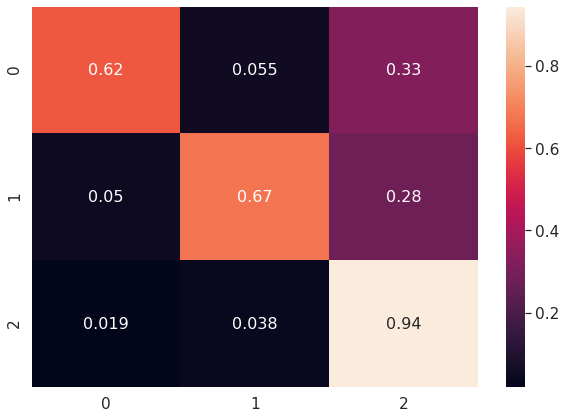

In [ ]:
evaluator = Evaluator(model, dev_dataset_)
evaluator.check_performance(idx2label)

In [ ]:
test_set_path = '/content/drive/My Drive/Bonus_NLP_HW2/MWE_test_set.tsv'
test_set = TSVDatasetParser(test_set_path, _device=device, is_testing_data=True)
test_set.encode_dataset(word2idx, label2idx, pos2idx)
test_dataset_ = DataLoader(dataset=test_set, batch_size=batch_size,
                           collate_fn=TSVDatasetParser.pad_batch)

In [ ]:
import json
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer 
  

nltk.download('wordnet', quiet=True)


def fetch_sense_info(multiword_token, data=None, is_babelnet=True):
    lemmatizer = WordNetLemmatizer() 
    lemma_word = lemmatizer.lemmatize(multiword_token.lower())
    if is_babelnet:
        if data is None:
            data = json.load(open(os.path.join(os.getcwd(), 'model', "it_en_lemma2synsets.json")))
        synsets = [val for key, val in data.items() if lemma_word.replace(' ', '_') in key]
        return ' '.join(flat_list(synsets))
    else:
        synsets = wn.synsets(lemma_word)
        if synsets is None or len(synsets) == 0:
            return " "

        sense_info = []
        for synset in synsets:
            sense_info.append('wn:' + str(synset.offset()).zfill(8) + synset.pos())
        return ' '.join(sense_info)


def print_extracted_mwes(preds):
    for i in range(len(preds)):
        curr_sentence = test_set.data_x[i]
        prediction_list = preds[i][:len(curr_sentence)]
        sentence_id = curr_sentence[0]
        indices = [i for i, x in enumerate(prediction_list) if x == "B"]
        if indices == []: continue
        mwes = []
        for idx in indices:
            curr_mwes = []
            curr_mwes.append(idx)
            preds_list = prediction_list[idx:]
            for idx_ in range(len(preds_list)):
                if preds_list[idx_] == 'O':
                    curr_mwes.append(idx + idx_ - 1)
                    mwes.append(curr_mwes)
                    break
        for mwe in mwes:
            start_token = mwe[0]
            end_token = mwe[1] + 1
            mwe_ = ' '.join([curr_sentence[i] for i in range(start_token, end_token)])
            sense_info = fetch_sense_info(mwe_)
            print(f'{sentence_id}\t{start_token}\t{end_token}\t{mwe_}\t{sense_info}')
        # print('_____________________________________________________________________')

In [ ]:
predictions = model.predict_sentences(test_dataset_)
preds = TSVDatasetParser.decode_predictions(predictions, idx2label)
print_extracted_mwes(preds)


1	1	3	Bus drivers	
2	2	4	autisti di	
3	5	8	gloved boxing styles	
3	15	17	varying degrees	
4	19	21	vari livelli	
5	4	6	word meaning	bn:00000657n
5	23	27	processes of linguistic negotiation	
5	28	30	discourse partners	
5	35	37	shared meanings	
6	5	8	significato delle parole	
6	23	27	processi di negoziazione linguistica	
6	43	45	parole della	
7	1	4	Word Sense Disambiguation	
7	9	12	lexical knowledge base	
8	2	7	disambiguazione dei significati delle parole	bn:00027425n
8	12	15	base di conoscenza	bn:00028142n
9	2	4	neural networks	
9	10	13	short-term memory units	
9	27	30	artificial neural network	
10	11	13	unità di	bn:00000481n bn:00002372n bn:00002266n bn:00002913n bn:00005523n bn:00006821n bn:00004991n bn:00006173n bn:00007609n bn:00014395n bn:00017803n bn:00021251n bn:00021255n bn:00021484n bn:00028936n bn:00030829n bn:00030829n bn:00027287n bn:00027459n bn:00021483n bn:00025315n bn:00028785n bn:00032353n bn:00035492n bn:00035492n bn:00035778n bn:00035780n bn:00047162n bn:00045793n bn:

In [ ]:
import multiprocessing
from gensim.models import Word2Vec


def train_pos2vec(training_data, w, embed_size, lr, epochs):
    cores = multiprocessing.cpu_count() 
    w2v_model = Word2Vec(min_count=5, window=w, size=embed_size, sample=1e-3,
                         alpha=lr, min_alpha=0.0007, negative=20, workers=cores-1)
    w2v_model.build_vocab(training_data, progress_per=10000)
    print(w2v_model)
    w2v_model.train(training_data, total_examples=w2v_model.corpus_count, epochs=epochs, report_delay=1)
    return w2v_model

def save_pos_embeddings(w2v_model, path_to_save):
    pos_embeds = [token for token in w2v_model.wv.vocab]

    with open(path_to_save, "w+") as f:
        for key in pos_embeds:
            f.write(f"{key} ")
            for el in w2v_model[key]:
                f.write(f"{el} ")
            f.write("\n")

INFO - 20:30:56: 'pattern' package not found; tag filters are not available for English


In [ ]:
model = train_pos2vec(training_set.pos_x, 10, 300, 1e-3, 30)
pos_embeddings_path = os.path.join(os.getcwd(), 'model', "pos_embeddings.npy")
save_pos_embeddings(model, pos_embeddings_path)

In [ ]:
# pos_pretrained_embeddings_ = torch.LongTensor(np.load(pos_embeddings_path)).to(device)

In [ ]:
import io


def load_pos_embeddings(file_name, word2idx, embeddings_size, save_to=None):
    if save_to is not None and os.path.exists(save_to):
        pretrained_embeddings = torch.from_numpy(np.load(save_to))
        
    else:
        fin = io.open(file_name, 'r', encoding='utf-8', newline='\n', errors='ignore')
        data = {}
        for line in tqdm(fin, desc=f'Reading data from {file_name}', leave=False):
            tokens = line.rstrip().split(' ')
            data[tokens[0]] = np.array(tokens[1:], dtype=np.float)

        pretrained_embeddings = torch.randn(len(word2idx), embeddings_size)
        initialised = 0
        for idx, word in enumerate(data):
            if word in word2idx:
                initialised += 1
                vector_ = torch.from_numpy(data[word])
                pretrained_embeddings[word2idx.get(word)] = vector_

        pretrained_embeddings[word2idx["<PAD>"]] = torch.zeros(embeddings_size)
        pretrained_embeddings[word2idx["<UNK>"]] = torch.zeros(embeddings_size)
        print(f'Loaded {initialised} vectors and instantiated random embeddings for {len(word2idx) - initialised}')
        if save_to is not None:
            np.save(save_to, pretrained_embeddings) # save the file as "outfile_name.npy"
    return pretrained_embeddings

In [ ]:
pos_embeddings_ = load_pos_embeddings(pos_embeddings_path, pos2idx, 300) 

Loaded 41 vectors and instantiated random embeddings for 4


In [ ]:
pos_embeddings_.shape

torch.Size([45, 300])

In [ ]:
!zip -r models_7517.zip model

  adding: model/ (stored 0%)
  adding: model/word_stoi.pkl (deflated 58%)
  adding: model/CRF BiLSTM_II Model with Bilingual & POS Embeddings_model.pth (deflated 8%)
  adding: model/word_itos.pkl (deflated 58%)
  adding: model/CRF BiLSTM_II Model with Bilingual & POS Embeddings_ckpt_best.pth (deflated 8%)
  adding: model/pos_itos.pkl (deflated 44%)
  adding: model/CRF BiLSTM_II Model with Bilingual & POS Embeddings_model.pt (deflated 8%)
  adding: model/pos_stoi.pkl (deflated 44%)
  adding: model/vocab_embeddings_vector.npy (deflated 8%)
  adding: model/CRF BiLSTM_II Model with Bilingual & POS Embeddings_ckpt_best.pt (deflated 8%)
  adding: model/CRF BiLSTM_II Model with Bilingual & POS Embeddings_confusion_matrix.png (deflated 16%)
